____


# Churn Risk Analysis and Predictive Model

### _~ Jonty, Ava, Tina_

___


In this workbook we will take a look at the data provided by Swan Teleco and use it to create and evaluate a model that accurately classifies churner customers. From here we will produce a list of the 500 customers most likely to churn in the future and identify possible insentives that would lower their likelyhood to churn.
#### Objectives:
* Explore the dataset and identify correlated features.
* Engineer features to create an effective model.
* Evaluate the model against the test & train data.
* Produce a list of the top 500 customers most likely to churn.

## <u>Exploratory Data Analysis</u>

First we can perform some initial data cleaning and exploration, finding any potential corrolations and patterns in the data set provided.

In [1]:
# Import all required libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [2]:
# Display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [3]:
# Read the dataset into a dataframe
df_original = pd.read_csv('Project_Data.csv')

# Inspect the first 5 rows of the dataframe
df_original.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


In [4]:
# Create a copy of the dataframe to use for data cleaning, feature engineering etc.
df = df_original.copy()

#### <u>Preliminary Data Analysis</u>

In [5]:
# Check if there are any duplicates
df.duplicated().sum()

# We find that there are none

0

In [6]:
# Check nulls
df.isna().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Reason         5174
dtype: int64

> There are nulls in the Churn Reason column. This is due to the fact that there cannot be a Churn Reason if the customer did not churn.  

Due to the high number of nulls, we will drop this column for the model.  

<u>**_Dropping Columns_**</u>

From inspecting the dataset, we can see that the 'Count', 'Country' and 'State' columns all contain one unique value.  

We can verify this by returning the number of unique values in these columns.

In [7]:
print("Number of Unique Values in df['Count']: ", df.Count.nunique())
print("Number of Unique Values in df['Country']: ", df.Country.nunique())
print("Number of Unique Values in df['State']: ", df.State.nunique())

Number of Unique Values in df['Count']:  1
Number of Unique Values in df['Country']:  1
Number of Unique Values in df['State']:  1


> As expected, the number of unique values in each of the columns is 1.  

So we can drop these columns from the dataframe.

In [8]:
df.drop(columns = ['Count', 'Country', 'State'], inplace = True)

We can also drop the following columns, as we will not be using them in the model for the reasons specified:
* **CustomerID, Zip Code:**
     * Too many unique values to OHE


* **Lat Long:**
     * Combination of Latitude and Longitude columns, so not necessary  


* **Churn Label:**
     * Values correspond with Churn Value (the target)  
     

* **Churn Reason:**
    * Too many nulls and too many unique values to OHE

In [9]:
df.drop(['CustomerID'
         ,'Zip Code'
         ,'Lat Long'
         ,'Churn Label'
         ,'City'
         ,'Churn Reason'
        ],
        axis=1,
        inplace=True
       )

## <u> Feature Engineering</u>

We can perform feature engineering to prepare for our model.

First, we find that there are empty values in the 'Total Charges' column, e.g. a whitespace character.  

In [10]:
# Return 5 rows that have Total Charges equal to a whitespace
# Select only tenure months and total charges columns
df[df['Total Charges'] == ' '][['Tenure Months', 'Total Charges']].head()

,Tenure Months,Total Charges
2234,0,
2438,0,
2568,0,
2667,0,
2856,0,


> Upon further inspection, we can see that these are empty because the Tenure Months column is equal to 0.  
> This makes sense, as the customer cannot pay anything if they are 0 months under tenure.  

In order to use this column in the model, we will replace these values with 0s, and then convert the column type to numeric.  

We can create a feature engineering function which performs this, as well as other required engineering. 

In [11]:
# Define the function that takes a dataframe
def feature_engineer(df):
    
    # Create a copy of the dataframe
    df = df.copy()

    ## We assume that 'no ___ service' imples they have not purchased 
    ## So we can replace this with 'No'
    
    # Select the columns that contain 'No phone service' entries
    cols_with_no_phone = ['Multiple Lines']

    # Select the columns that contain 'No internet service' entries
    cols_with_no_internet = ['Online Security', 
                             'Online Backup',
                             'Tech Support'
                            ]

    # Replace 'No phone service' with 'No'
    for col in cols_with_no_phone:
        df[col] = df[col].replace({'No phone service':'No'})

    # Replace 'No internet service' with 'No'
    for col in cols_with_no_internet:
        df[col] = df[col].replace({'No internet service':'No'})

    # Replace all yes/no objects with boolean mask
    df = df.replace({'Yes': 1, 'No': 0})

    # Replace all male/female objects with boolean mask
    df = df.replace({'Male':1, 'Female':0})

    # Replace all empty total charges with 0
    # Then set column to numeric
    df['Total Charges'] = pd.to_numeric(df['Total Charges'].replace(' ', 0))

    # OHE all remaining non-numeric columns
    df = pd.get_dummies(df,drop_first=True)

    return df

In [12]:
# Apply feature engineering on the dataframe
df = feature_engineer(df)
df.head()

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Tech Support,Paperless Billing,Monthly Charges,Total Charges,Churn Value,Internet Service_DSL,Internet Service_Fiber optic,Device Protection_1,Device Protection_No internet service,Streaming TV_1,Streaming TV_No internet service,Streaming Movies_1,Streaming Movies_No internet service,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,33.964131,-118.272783,1,0,0,0,2,1,0,1,1,0,1,53.85,108.15,1,1,0,0,0,0,0,0,0,0,0,0,0,1
1,34.059281,-118.307420,0,0,0,1,2,1,0,0,0,0,1,70.70,151.65,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,34.048013,-118.293953,0,0,0,1,8,1,1,0,0,0,1,99.65,820.50,1,0,1,1,0,1,0,1,0,0,0,0,1,0
3,34.062125,-118.315709,0,0,1,1,28,1,1,0,0,1,1,104.80,3046.05,1,0,1,1,0,1,0,1,0,0,0,0,1,0
4,34.039224,-118.266293,1,0,0,1,49,1,1,0,1,0,1,103.70,5036.30,1,0,1,1,0,1,0,1,0,0,0,0,0,0


Now we can check the data types of the rest of the columns.

In [13]:
df.dtypes

Latitude                                  float64
Longitude                                 float64
Gender                                      int64
Senior Citizen                              int64
Partner                                     int64
Dependents                                  int64
Tenure Months                               int64
Phone Service                               int64
Multiple Lines                              int64
Online Security                             int64
Online Backup                               int64
Tech Support                                int64
Paperless Billing                           int64
Monthly Charges                           float64
Total Charges                             float64
Churn Value                                 int64
Internet Service_DSL                        uint8
Internet Service_Fiber optic                uint8
Device Protection_1                         uint8
Device Protection_No internet service       uint8


> We can see that all columns are now numeric and ready to be used in our model.

## <u>Further EDA</u>

#### <u>*Feature Correlation Analysis*</u>
Using a correlation heatmap, the relationship between the target 'Churn Value' and categorical/numerical data can be determined.

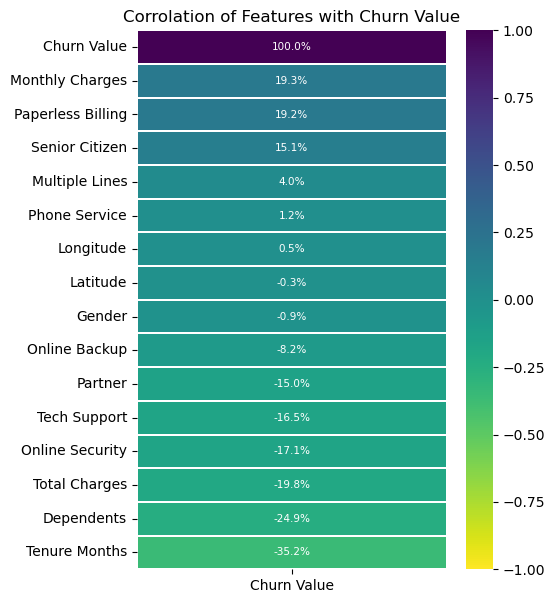

In [14]:
# We plot only the columns which have not been one-hot-encoded
# This is to prevent an overly confusing graph
# So select only columns with index 0 to 15
correlation_columns = df.iloc[:, :16]

# Set figure size
plt.figure(figsize = (5, 7))

# Calculate the correlation matrix
corr_m = correlation_columns.corr()

# Show only the correlations with Churn value, as these are the only ones we're interested in
# Sort by correlation
churn_corr = corr_m[['Churn Value']].sort_values(by='Churn Value',ascending=False)

# Plot the matrix as a heatmap
sns.heatmap(churn_corr,
            annot = True,                 # adding labels
            annot_kws={"fontsize":7.5},   # adjusting font size
            fmt = '.1%',                  # rounding
            vmin = -1,                    # set minimum limit
            vmax = +1,                    # set maximum limit
            cmap = 'viridis_r',           # set colour map
            linewidths=0.1,               # adding whitespace for readability
           )

# Display the matrix
plt.title('Corrolation of Features with Churn Value')
plt.show()

> We can see that Gender, Longitude and Latitude have the smallest correlations with the Churn Value.  

We can visualise some of the relationships using ``countplot()`` to compare the distribution of churners based on categorical data.  

For example, we can look at the proportion of churners for the Gender and Senior Citizen categories.

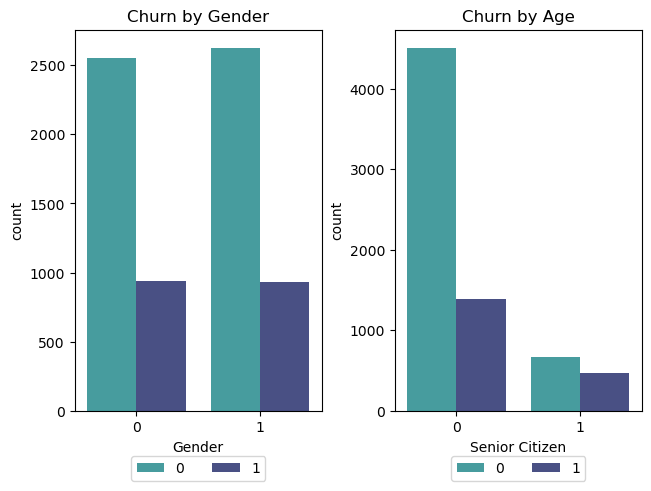

In [15]:
# Create a figure with 2 subplots side-by-side
# SOURCES:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots
# https://matplotlib.org/stable/users/explain/axes/constrainedlayout_guide.html
fig, ax = plt.subplots(1,2,layout = 'constrained')

# Create a count plot for the Gender column
# Which counts how many churners and non-churners there are for each gender
sns.countplot(data=df, 
              x='Gender',        # split by gender
              palette='mako_r',  # set colour palette
              hue='Churn Value', # colour based on the churn value
              ax=ax[0]         # plot on the first axis (i.e. left hand side)
             )

# Label the graph
ax[0].set_title('Churn by Gender')

# Create a count plot for the Gender column
# Which counts how many churners and non-churners there are for each age group
# (Senior vs Non-Senior)
sns.countplot(data=df,      
              x='Senior Citizen', # split by age group
              palette='mako_r',   # set colour palette
              hue='Churn Value',  # colour based on churn value
              ax=ax[1]          # plot on the second axis (i.e. right hand side)
             )

# Label the graph
ax[1].set_title('Churn by Age')

# Move the legends below the graphs so that they don't cover the bars
# SOURCE: https://www.geeksforgeeks.org/python/matplotlib-axes-axes-legend-in-python/
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Display the plots
plt.show()

> From the graph on the left, we see that there is no significant corrolation between customer churn and gender, as the bars are almost identical for both female (0) and male (1).

> However, from the graph on the right, we can see that a higher proportion of senior customers appear to be churning compared to non-senior customers.  

#### <u>*Proportion of Churners Data*</u>

We can inspect the number 'churners' in the dataset, and the number of 'non-churners', to inspect the proportion of these.

In [16]:
df['Churn Value'].value_counts()

0    5174
1    1869
Name: Churn Value, dtype: int64

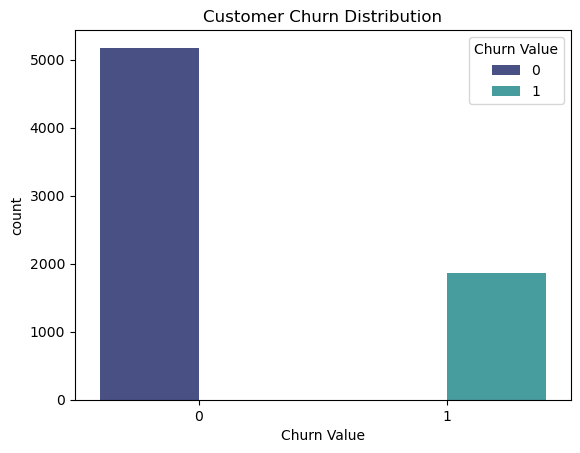

In [17]:
# Plot the churn imbalance as a countplot

sns.countplot(data=df
              ,x='Churn Value'      # count the churn value
              ,palette='mako'       # set the colour palette
              ,hue='Churn Value'    # colour the graphs based on the churn value
             )

# Add a title to the graph
plt.title('Customer Churn Distribution')

# Display the graph
plt.show()

> We can see that there are many more observations for 'non-churners' than for 'churners'.  

_**This is one of the reasons that we will be focusing on the Recall statistic when evaluating our models.**_

## <u> Train-Test-Split</u>

Now we can perform the train-test-split to use in the models.  

First we define the feature columns.

In [18]:
# Set feature columns
feature_columns = ['Latitude', 
                   'Longitude', 
                   'Gender', 
                   'Senior Citizen', 
                   'Partner',
                   'Dependents', 
                   'Tenure Months', 
                   'Phone Service', 
                   'Multiple Lines',
                   'Online Security', 
                   'Online Backup', 
                   'Tech Support', 
                   'Paperless Billing',
                   'Monthly Charges', 
                   'Total Charges',
                   'Internet Service_DSL', 
                   'Internet Service_Fiber optic',
                   'Device Protection_1', 
                   'Device Protection_No internet service',
                   'Streaming TV_1', 
                   'Streaming TV_No internet service',
                   'Streaming Movies_1', 
                   'Streaming Movies_No internet service',
                   'Contract_One year', 
                   'Contract_Two year',
                   'Payment Method_Credit card (automatic)',
                   'Payment Method_Electronic check', 
                   'Payment Method_Mailed check'
       ]

In [19]:
# Define the features, X, and the target, y
X = df[feature_columns]
y = df['Churn Value']

In [20]:
# Perform the split and assign to corresponding variables
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,     # select 20% test data
                                                    random_state=42,   # fix the random state
                                                    stratify = y       # stratify the data
                                                   )

## <u>Scaling</u>


We can scale the non-binary data for the logistic regression model. We do this because there is a large difference in magnitudes between the numerical columns (e.g. Latitude and Longitude) and the binary columns.

We choose the robust scaler as it is more sensitive to outliers.

In [21]:
# Select the columns we need to scale
scale_columns = ['Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges', 'Total Charges']

# Create a copy of X_train and X_test
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Initialise the scaler
scaler = RobustScaler()

In [22]:
# Fit and transform the scaler to the train data
# Select only the specified columns to scale
# Then update these columns in the dataframe
X_train_scaled[scale_columns] = scaler.fit_transform(X_train_scaled[scale_columns])

In [23]:
# Transform the specified columns in the test data
# Update these columns in the dataframe
X_test_scaled[scale_columns] = scaler.transform(X_test_scaled[scale_columns])

## <u> Modelling</u>

We consider recall to be most appropriate metric to optimise in the model.  This is for the following reasons:

* There is an imbalance in the dataset between number of churners and non-churners   


* We prefer false positives over false negatives because:
    * Customers incorrectly classified as churners would probably still have a high risk of churning the following quarter, and should still be given incentives to stay.
    * Customers incorrectly classified as non-churners would not receive any incentives/marketing to stay, and would be lost as customers.

We want to minimise the number of customers who are not identified as high risk, not given incentives, and then churn.

We can consider both the Logistic Regression Model and the Random Forest Model, to see which one gives us a higher recall score.  

First, we look at the Logistic Regression Model.

### <u>Logistic Regression Model</u>

**_Model Creation_**

In [24]:
# Create a copy of the scaled X_train and X_test for this model

X_train_log = X_train_scaled.copy()
X_test_log = X_test_scaled.copy()

In [25]:
# Initialise the logistic regression model
logreg = LogisticRegression(max_iter=600, random_state=42)

In [26]:
# Fit the model to the train data
logreg.fit(X_train_log,y_train)

LogisticRegression(max_iter=600, random_state=42)

In [27]:
# Use the model to predict the probability that a customer churns, and probability that a customer remains
# Create two new columns to store these probabilities
X_test_log[['prob_churn', 'prob_remain']] = logreg.predict_proba(X_test_log)

# Display the first 5 rows to see the output
X_test_log.head(1)

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Tech Support,Paperless Billing,Monthly Charges,Total Charges,Internet Service_DSL,Internet Service_Fiber optic,Device Protection_1,Device Protection_No internet service,Streaming TV_1,Streaming TV_No internet service,Streaming Movies_1,Streaming Movies_No internet service,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,prob_churn,prob_remain
2196,-0.324704,0.712792,1,0,1,0,0.934783,1,1,1,1,1,1,0.801472,2.060467,0,1,1,0,1,0,1,0,0,1,1,0,0,0.934249,0.065751


In [28]:
# Create a column containing the predicted target values
# If the probability of churning is >= 0.5, then set the target to 1
# Otherwise set it to 0
X_test_log['y_pred'] = np.where(X_test_log['prob_churn'] >= 0.5, 1, 0)

# Display the first row to see the output
X_test_log.head(1)

,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,Tech Support,Paperless Billing,Monthly Charges,Total Charges,Internet Service_DSL,Internet Service_Fiber optic,Device Protection_1,Device Protection_No internet service,Streaming TV_1,Streaming TV_No internet service,Streaming Movies_1,Streaming Movies_No internet service,Contract_One year,Contract_Two year,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,prob_churn,prob_remain,y_pred
2196,-0.324704,0.712792,1,0,1,0,0.934783,1,1,1,1,1,1,0.801472,2.060467,0,1,1,0,1,0,1,0,0,1,1,0,0,0.934249,0.065751,1


_**Evaluation**_

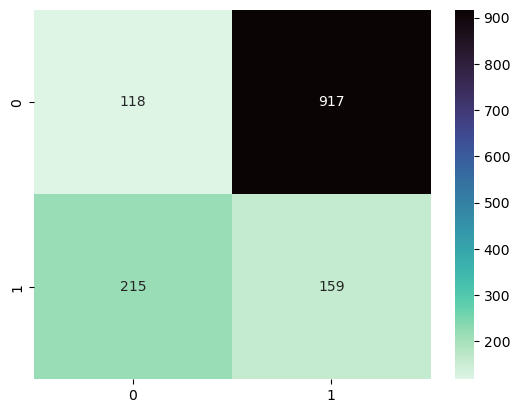

In [29]:
# Create a confusion matrix
cm = metrics.confusion_matrix(y_test, X_test_log['y_pred'])

# Plot the matrix as a heatmap

sns.heatmap(cm,                # plot confusion matrix
            cmap='mako_r',     # set colour palette
            annot=True,        # show annotations
            fmt = 'g'          # display numbers in regular format, not scientific notation
           )

# Display the heatmap
plt.show()

> There are a large number of false positives and false negatives.

In [30]:
# Define a function that takes the actual y value and the predicted y value
# And returns discrete metrics accuracy, recall, precision, f1

def get_results(actual, predicted):
    print(f'The accuracy of your model is: {metrics.accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {metrics.recall_score(actual, predicted)}')
    print(f'The precision of your model is: {metrics.precision_score(actual, predicted)}')
    print(f'The F1-score of your model is: {metrics.f1_score(actual, predicted)}')

In [31]:
# Use the function on the test data
get_results(y_test, X_test_log['y_pred'])

The accuracy of your model is: 0.19659332860184528
The recall of your model is: 0.42513368983957217
The precision of your model is: 0.14776951672862454
The F1-score of your model is: 0.2193103448275862


> We find that the recall score is very low (43%), so this is a poorly performing model.  

Next, we look at the Random Forest Model.

### <u>Random Forest Model</u>

In [32]:
# Make a copy of X_train and X_test for this model

X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

**_Model Optimisation_**

We can initialise the Random Forest model. 

<u>Feature Importance</u>

First we can create a base model and investigate the importance of each feature.

In [33]:
# Initialise the model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
# Train the model
rf.fit(X_train_rf, y_train)

# Calculate the feature importances
fi = rf.feature_importances_

# Display the column and the importance of the column as a dataframe
importances = pd.DataFrame(zip(X_train.columns, fi), columns = ['Columns', 'Importance'])

# Display in order of most important first
importances.sort_values('Importance', ascending = False, inplace = True)

importances

,Columns,Importance
14,Total Charges,0.144178
6,Tenure Months,0.132892
13,Monthly Charges,0.117317
0,Latitude,0.102856
1,Longitude,0.101666
16,Internet Service_Fiber optic,0.040252
26,Payment Method_Electronic check,0.035948
5,Dependents,0.034825
24,Contract_Two year,0.029563
12,Paperless Billing,0.020116


> We find that Total Charges, Tenure Months, Monthly Charges are the three most important in the base model.

<u>Cross Validation</u>

We can calculate the cross validation score on the base model to get an estimate of how it will perform.

In [34]:
scores = cross_val_score(rf, 
                         X_train_rf,          # use train features
                         y_train,             # use train target
                         cv = 5,              # perform 5 splits
                         scoring = 'recall'   # return the recall score
                        )

# Calculate the average of these scores
sum(scores)/len(scores)

0.5117056856187291

> We get a low recall score of 51%.

<u>Grid Search</u>

So we can now initiate a Grid Search to optimise the model.

In [35]:
# Set the parameters we want to search
# We ran the Grid Search multiple times to obtain the best parameter ranges
# And we found these to give the highest recall score on the test data

param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [12, 16, 18],
    'min_samples_split': [8, 14, 16],
    'min_samples_leaf': [2, 5, 8],
    'class_weight': ['balanced']
}

In [36]:
# Re-initialise the classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Run Grid Search
search = GridSearchCV(estimator=rf
                      , param_grid=param_grid   # set parameters
                      , scoring= 'recall'       # use recall to assess the model
                      , cv= 5                   # perform 5 splits
                      , n_jobs= -1              # speed up the grid search
                     )

# Fit the Grid Search to the train data
search.fit(X_train_rf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [12, 16, 18],
                         'min_samples_leaf': [2, 5, 8],
                         'min_samples_split': [8, 14, 16],
                         'n_estimators': [300, 400, 500]},
             scoring='recall')

In [37]:
# Print the best parameters
print(search.best_params_)

# Print the best recall score
print(search.best_score_)

# fit the model with the best parameters
best_rf = search.best_estimator_
best_rf.fit(X_train_rf, y_train)

{'class_weight': 'balanced', 'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 300}
0.7618729096989967


RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=8, min_samples_split=8,
                       n_estimators=300, n_jobs=-1, random_state=42)

> We get the best recall score of 0.76187 (~76%), which is a large improvement from the base model, meaning that the Grid Search has effectively optimised the model.

<u>Recalculate Feature Importance</u>

We can now recalculate the feature importances and see which features contribute most to the model.

In [38]:
# We can re-calculate the feature importances
fi = best_rf.feature_importances_

# Display the column and the importance of the column as a dataframe
# Display in order of most important first
importances = pd.DataFrame(zip(X_train.columns, fi), columns = ['Columns', 'Importance'])

importances.sort_values('Importance', ascending = False, inplace = True)

importances

,Columns,Importance
6,Tenure Months,0.158304
14,Total Charges,0.114626
24,Contract_Two year,0.099479
13,Monthly Charges,0.083070
5,Dependents,0.076261
16,Internet Service_Fiber optic,0.069469
26,Payment Method_Electronic check,0.051949
0,Latitude,0.043090
1,Longitude,0.040425
23,Contract_One year,0.038860


We can visualise the columns with the highest feature importance as follows.

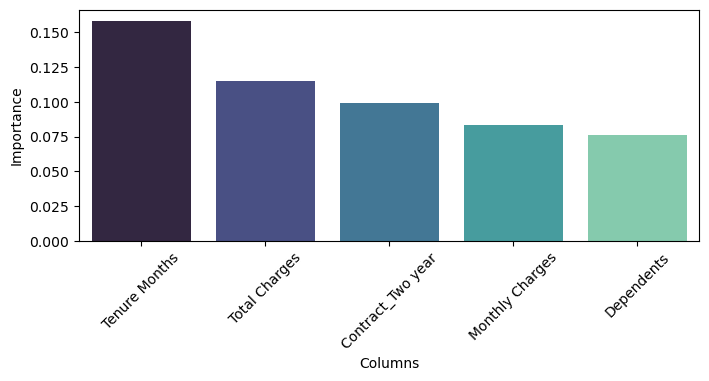

In [39]:
# Set figure size
plt.figure(figsize=(8,3))

# Select only the top 5 columns with highest feature importance to plot
top_cols = importances.head()

# Plot a barchart
sns.barplot(data = top_cols,   # use top 5
            x = 'Columns',     # column names on x axis
            y = 'Importance',  # feature importance on y axis
            palette = 'mako',  # set colour palette
           )

# Adjust column labels
plt.xticks(rotation = 45,
          fontweight = 'light')

# Display the graph
plt.show()

The columns with the highest feature importance now differ from the initial model as a result of optimisation. The most important factors are now:
* Tenure Months
* Total Charges
* Two year contract
* Monthly Charges
* Dependents

_**Evaluation on Train Set**_

We can create a prediction on the train set and calculate the weighted average recall to compare with the test set to check for overfitting.

In [40]:
# Create a prediction on train set
y_pred_rf = best_rf.predict(X_train_rf)

# Calculate probabilities of not churning and churning
y_prob_rf = best_rf.predict_proba(X_train_rf)

In [41]:
# Copy the Train dataframe
rf_train_results = X_train_rf.copy()

# Create a column to store the predicted values from the model
rf_train_results['y_pred'] = y_pred_rf

# Create a column to store the real values
rf_train_results['y_real'] = y_train

# Create a column to store the probability of churning
rf_train_results['y_prob_1'] = y_prob_rf[:,1]

In [42]:
# Evaluate new model on train data
print(metrics.classification_report(y_train, y_pred_rf))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88      4139
           1       0.64      0.87      0.74      1495

    accuracy                           0.84      5634
   macro avg       0.80      0.85      0.81      5634
weighted avg       0.87      0.84      0.84      5634



> We get a weighted average recall of 84% for the train data. We can compare this with the test set.

_**Evaluation on Test Set**_

In [43]:
# Create a prediction on test set
y_pred_test_rf = best_rf.predict(X_test_rf)

# Calculate probabilities of not churning and churning
y_prob_test_rf = best_rf.predict_proba(X_test_rf)

In [44]:
# Copy the Test dataframe
rf_test_results = X_test_rf.copy()

# Create a column to store the predicted values from the model
rf_test_results['y_pred'] = y_pred_test_rf

# Create a column to store the real values
rf_test_results['y_real'] = y_test

# Create a column to store the probability of churning
rf_test_results['y_prob_1'] = y_prob_test_rf[:,1]

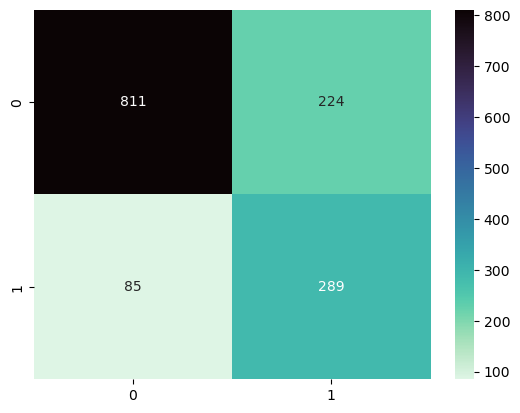

In [45]:
##Create confusion matrix
cm_rf = metrics.confusion_matrix(y_test, y_pred_test_rf)

# Plot the matrix as a heatmap
sns.heatmap(cm_rf,             # plot confusion matrix
            cmap='mako_r',     # set colour palette
            annot=True,        # show annotations
            fmt = 'g'          # display numbers in regular format, not scientific notation
           )

# Display the heatmap
plt.show()

> The confusion matrix has a larger number of false positives than false negatives.  
> This shows that the model falsely classifies a customer as a churner more often than it falsely classifies a customer as a non-churner.

This is to be expected: there are more non-churners in the dataset (who could be mis-identified as churners) than there are churners (who could be mis-identified as non-churners).

The result is that most actual churners are correctly identified, giving a high recall score, but the model also falsely identifies many non-churners as churners, giving a relatively low precision score.

In [46]:
# Evaluate new model on test data
print(metrics.classification_report(y_test, y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1035
           1       0.56      0.77      0.65       374

    accuracy                           0.78      1409
   macro avg       0.73      0.78      0.75      1409
weighted avg       0.81      0.78      0.79      1409



> The weighted recall score for this model is 78%, meaning that the model performed decently well.  
> This means that 78% of all actual churners were correctly picked up by the model.  

> The weighted recall for the test set does not differ greatly from the train set, so the model has not been overfitted.

The recall score is much higher for the Random Forest Model than for the Logistic Regression Model, so we choose the Random Forest Model to calculate the churn risk for all remaining customers.  

### <u>Probability of Churning for All Remaining Customers</u>

Now we can create a CSV file with the churn risk (probability of churning) for all remaining customers.

In [47]:
# Create a copy of df which only has the rows with 'Churn Value' == 0
# i.e. shows which customers are remaining
# We will use this dataframe to find the churn risk
df_remain = df[df['Churn Value'] == 0].copy()

# Do the same with df_original
# We will use this dataframe to get the corresponding customer IDs
df_all_cols_remain = df_original[df_original['Churn Value'] == 0].copy()

In [48]:
# Remove the target column from df_remain for the prediction
df_features = df_remain.drop(columns = 'Churn Value')

# And remove columns which we removed during modelling

# Predict the churn risk for all customers and save as a new variable
churn_risk = best_rf.predict_proba(df_features)

# Save the probability of churning as a new column in df_all_cols_remain
df_all_cols_remain['Likelihood of Churning'] = churn_risk[:,1]

# Select only the Customer ID and Likelihood of Churning columns
churn_risk_df = df_all_cols_remain[['CustomerID', 'Likelihood of Churning']]

In [49]:
# Create a CSV file
churn_risk_df.to_csv('Churn_Risk_All_Customers.csv', index=False)

Now we can create a CSV file with the top 500 customers most likely to churn.

In [50]:
# Sort by churn risk descending
# Return only top 500 rows
top500 = churn_risk_df.sort_values('Likelihood of Churning', ascending = False).head(500)

In [51]:
# Create a CSV file
top500.to_csv('500_Most_Likely_to_Churn.csv', index = False)